In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max.columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from bayes_opt import BayesianOptimization

import matplotlib.pyplot as plt
plt.rc("font", family= "AppleGothic") # 라이브러리 불러오기와 함께 한번만 실행

ModuleNotFoundError: No module named 'bayes_opt'

In [ ]:
df = pd.read_csv('.data/for_ship_model.csv')

In [43]:
df.columns = ['ETA_Year', 'ETA_Month', 'ETA_Day', 'ETA_Hour', '호출부호', '접안_대기시간_분',
       '계선장소명', '선박용도', 'Service_Time_분', '대기율', '총톤수', '재화중량톤수',
       '선박_총길이', '선박_너비', '선박_만재흘수', '선박_깊이', '선박_길이1', '풍속',
       '풍향', 'GUST풍속', '현지기압', '습도', '기온', '수온',
       '최대파고', '유의파고', '평균파고', '파주기', '파향', '이전_입항선박수',
       '연도별_선석점유율', '시설연평균_재화중량톤수', '연평균_총입항건수', '선박_연평균_서비스시간', '선박_연평균_대기시간',
       '호출부호_encoded', '계선장소명_encoded', '선박용도_encoded']

x_cols = ['ETA_Year', 'ETA_Month', 'ETA_Day', 'ETA_Hour', 
       'Service_Time_분','총톤수', '재화중량톤수',
       '선박_총길이', '선박_너비', '선박_만재흘수', '선박_깊이', '선박_길이1', '풍속',
       '풍향', 'GUST풍속', '현지기압', '습도', '기온', '수온',
       '최대파고', '유의파고', '평균파고', '파주기', '파향', '이전_입항선박수',
       '연도별_선석점유율', '시설연평균_재화중량톤수', '연평균_총입항건수', '선박_연평균_서비스시간', '선박_연평균_대기시간',
       '호출부호_encoded', '계선장소명_encoded', '선박용도_encoded']

display_cols = ['ETA_Year', 'ETA_Month', 'ETA_Day', 'ETA_Hour', 
       'Service_Time_분', '대기율', '총톤수', '재화중량톤수',
       '선박_총길이', '선박_너비', '선박_만재흘수', '선박_깊이', '선박_길이1', '이전_입항선박수',
       '연도별_선석점유율', '시설연평균_재화중량톤수', '연평균_총입항건수', '선박_연평균_서비스시간', '선박_연평균_대기시간', 
        '풍속',
       '풍향', 'GUST풍속', '현지기압', '습도', '기온', '수온',
       '최대파고', '유의파고', '평균파고', '파주기', '파향','접안_대기시간_분']
df.head(2)

,ETA_Year,ETA_Month,ETA_Day,ETA_Hour,호출부호,접안_대기시간_분,계선장소명,선박용도,Service_Time_분,대기율,총톤수,재화중량톤수,선박_총길이,선박_너비,선박_만재흘수,선박_깊이,선박_길이1,풍속,풍향,GUST풍속,현지기압,습도,기온,수온,최대파고,유의파고,평균파고,파주기,파향,이전_입항선박수,연도별_선석점유율,시설연평균_재화중량톤수,연평균_총입항건수,선박_연평균_서비스시간,선박_연평균_대기시간,호출부호_encoded,계선장소명_encoded,선박용도_encoded
0,2020,1,1,1,88238,0,SK2부두 01,석유제품 운반선,430.0,0.0,700.0,0.0,70.9,12.0,3.9,5.35,66.01,9.3,330.0,12.2,1028.8,43.0,4.3,17.5,4.2,2.8,2.0,10.7,49.0,0,4.143219,2073.888986,1729.000000,1452.987426,572.048817,0,0,0
1,2020,1,1,3,DSRB9,0,가스부두,LPG 운반선,710.0,0.0,2689.0,2999.0,96.0,15.0,7.2,7.20,90.10,12.6,315.0,15.3,1028.5,44.0,4.3,17.4,3.9,2.2,1.5,9.1,48.0,0,1.742879,3935.463021,418.333333,970.370370,215.740741,1,1,1


In [39]:
df[display_cols].sample(7)

,ETA_Year,ETA_Month,ETA_Day,ETA_Hour,Service_Time_분,대기율,총톤수,재화중량톤수,선박_총길이,선박_너비,선박_만재흘수,선박_깊이,선박_길이1,이전_입항선박수,연도별_선석점유율,시설연평균_재화중량톤수,연평균_총입항건수,선박_연평균_서비스시간,선박_연평균_대기시간,풍속,풍향,GUST풍속,현지기압,습도,기온,수온,최대파고,유의파고,평균파고,파주기,파향,접안_대기시간_분
50759,2022,12,25,15,675.0,122.222222,610.0,1228.0,68.80,10.6,4.0,4.60,64.00,1,1.125984,4313.537159,188.666667,869.165509,593.881965,12.400000,309.000000,15.800000,1016.20000,48.000000,8.700000,17.700000,5.500000,2.700000,1.900000,10.700000,69.000000,825
32522,2021,12,4,0,235.0,0.000000,919.0,1501.0,72.00,11.6,4.0,5.95,72.00,0,1.201603,1449.208295,477.000000,1110.065938,0.000000,11.300000,314.000000,15.100000,1019.20000,56.000000,10.300000,18.800000,2.700000,1.900000,1.300000,7.100000,55.000000,0
23590,2021,5,27,21,215.0,0.000000,1130.0,2286.0,62.20,10.0,5.0,5.95,74.00,5,1.669914,2942.975883,901.666667,1788.816877,0.000000,10.400000,228.000000,12.700000,1002.40000,88.000000,18.600000,18.800000,2.300000,1.400000,1.000000,5.300000,245.000000,0
22606,2021,5,8,4,1480.0,41.891892,4969.0,9325.0,113.95,18.4,7.9,9.80,108.00,0,2.314153,10087.017026,340.000000,4555.323308,823.389724,3.234886,325.531056,4.446273,1007.70000,64.000000,16.800000,16.700000,1.600000,1.000000,0.700000,5.300000,202.000000,620
25052,2021,6,28,15,1490.0,0.000000,7411.0,12585.0,126.50,20.3,8.9,11.50,118.42,0,1.970294,5312.995470,541.333333,2925.277778,55.000000,5.576283,227.190422,6.919156,1010.67138,90.285063,24.568871,23.052223,1.283352,0.721437,0.521437,3.466705,111.885975,0
37858,2022,3,20,13,1988.0,0.000000,12105.0,20866.0,147.80,60.0,12.0,24.20,147.80,0,2.182838,9223.682057,88.666667,1988.000000,0.000000,2.000000,136.000000,4.100000,1018.60000,68.000000,9.200000,14.400000,2.200000,1.600000,1.200000,8.000000,56.000000,0
9083,2020,7,15,14,1470.0,73.129252,8581.0,13119.0,128.60,20.4,8.7,11.50,120.85,0,3.625837,6519.097016,725.333333,2224.470833,1236.570833,5.800000,322.802632,7.500000,1006.40000,82.000000,21.600000,22.400000,2.600000,1.600000,1.100000,7.100000,14.000000,1075


In [40]:
df[display_cols].iloc[:,19:].tail(7)

,풍속,풍향,GUST풍속,현지기압,습도,기온,수온,최대파고,유의파고,평균파고,파주기,파향,접안_대기시간_분
50994,10.0,319.0,13.1,1029.0,57.0,5.6,16.1,2.3,1.3,1.0,4.3,335.0,0
50995,10.0,319.0,13.1,1029.0,57.0,5.6,16.1,2.3,1.3,1.0,4.3,335.0,0
50996,11.4,310.0,14.4,1028.7,64.0,5.7,16.1,2.2,1.6,1.1,5.3,0.0,0
50997,11.4,310.0,14.4,1028.7,64.0,5.7,16.1,2.2,1.6,1.1,5.3,0.0,0
50998,12.2,312.0,16.1,1029.3,60.0,5.6,16.1,2.3,1.5,1.1,5.8,36.0,0
50999,7.3,298.0,9.8,1027.6,49.0,7.8,16.1,2.4,1.5,1.0,5.8,6.0,0
51000,4.8,271.0,8.2,1027.6,47.0,8.0,16.2,2.2,1.3,0.9,5.8,33.0,0


In [41]:
df[x_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51001 entries, 0 to 51000
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ETA_Year        51001 non-null  int64  
 1   ETA_Month       51001 non-null  int64  
 2   ETA_Day         51001 non-null  int64  
 3   ETA_Hour        51001 non-null  int64  
 4   Service_Time_분  51001 non-null  float64
 5   대기율             51001 non-null  float64
 6   총톤수             51001 non-null  float64
 7   재화중량톤수          51001 non-null  float64
 8   선박_총길이          51001 non-null  float64
 9   선박_너비           51001 non-null  float64
 10  선박_만재흘수         51001 non-null  float64
 11  선박_깊이           51001 non-null  float64
 12  선박_길이1          51001 non-null  float64
 13  풍속              51001 non-null  float64
 14  풍향              51001 non-null  float64
 15  GUST풍속          51001 non-null  float64
 16  현지기압            51001 non-null  float64
 17  습도              51001 non-null 

## 231122. 종속변수 포함된 독립변수 제거 (1044)

In [49]:
from sklearn.model_selection import KFold

x_cols = ['ETA_Year', 'ETA_Month', 'ETA_Day', 'ETA_Hour', 
       'Service_Time_분','총톤수', '재화중량톤수',
       '선박_총길이', '선박_너비', '선박_만재흘수', '선박_깊이', '선박_길이1', '풍속',
       '풍향', 'GUST풍속', '현지기압', '습도', '기온', '수온',
       '최대파고', '유의파고', '평균파고', '파주기', '파향', '이전_입항선박수',
       '시설연평균_재화중량톤수', '연평균_총입항건수', '선박_연평균_서비스시간',
       '호출부호_encoded', '계선장소명_encoded', '선박용도_encoded']

# 데이터 불러오기 (주어진 데이터 사용)
data = df.copy()

# 특성과 타겟 변수 분리
X = data[x_cols]
y = data['접안_대기시간_분']

# 베이지안 옵티마이제이션 범위 설정
pbounds = {
    'num_leaves': (2, 100),           # num_leaves의 범위 설정
    'learning_rate': (0.01, 0.3),    # learning_rate의 범위 설정
    'feature_fraction': (0.1, 0.9),  # feature_fraction의 범위 설정
    'max_depth': (3, 30),
    'min_child_samples': (1, 50),     # min_child_samples의 범위 설정
    'reg_lambda': (0, 1)              # reg_lambda의 범위 설정
}

# 베이지안 옵티마이제이션 함수 정의
def lgb_cv(num_leaves, learning_rate, feature_fraction, max_depth, min_child_samples, reg_lambda):
    params = {
        'objective': 'regression',  # 회귀 문제 설정
        'metric': 'rmse',          # 평가 지표 (Root Mean Squared Error)
        'num_leaves': int(num_leaves),
        'learning_rate': max(min(learning_rate, 1), 0),  # learning_rate를 0과 1 사이로 제한
        'feature_fraction': max(min(feature_fraction, 1), 0),  # feature_fraction을 0과 1 사이로 제한
        'max_depth':int(max_depth),
        'min_child_samples': int(min_child_samples),
        'reg_lambda': max(min(reg_lambda, 1), 0)
    }

    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    rmses = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model = lgb.LGBMRegressor(**params)

        # 모델 학습
        model.fit(X_train, y_train)

        # 검증 데이터로 예측
        y_pred = model.predict(X_val)

        # 모델 평가 (RMSE 계산)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)

    return -np.mean(rmses)  # 목적 함수는 최소화해야 하므로 음수로 반환

# BayesianOptimization 객체 생성
optimizer = BayesianOptimization(
    f=lgb_cv,  # 최적화할 함수 지정
    pbounds=pbounds,  # 변수 범위 지정
    random_state=42,  # 랜덤 시드 설정
    verbose=2  # 로그 출력 레벨 설정
)

# 최적화 실행
optimizer.maximize(init_points=5, n_iter=10)

# 최적 하이퍼파라미터 출력
best_params = optimizer.max['params']
print("최적 하이퍼파라미터:", best_params)

# 최적 하이퍼파라미터로 모델 학습 및 평가
kf = KFold(n_splits=5, random_state=42, shuffle=True)
test_rmses = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    best_model = lgb.LGBMRegressor(
        objective='regression',
        metric='rmse',
        num_leaves=int(best_params['num_leaves']),
        learning_rate=best_params['learning_rate'],
        feature_fraction=best_params['feature_fraction'],
        min_child_samples=int(best_params['min_child_samples']),
        reg_lambda=best_params['reg_lambda']
    )

    # 모델 학습
    best_model.fit(X_train, y_train)

    # 검증 데이터로 예측
    y_pred = best_model.predict(X_val)

    # 모델 평가 (RMSE 계산)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    test_rmses.append(rmse)


# 예측 결과값의 범위 출력
print("예측 결과값 범위:")
print(f"최소 예측값: {np.min(y_pred)}")
print(f"최대 예측값: {np.max(y_pred)}")

print(f'평균 검증 RMSE (최적 모델): {np.mean(test_rmses)}')

# 최적 하이퍼파라미터로 모델 학습
best_model = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    num_leaves=int(best_params['num_leaves']),
    learning_rate=best_params['learning_rate'],
    feature_fraction=best_params['feature_fraction'],
    max_depth=int(best_params['max_depth']),
    min_child_samples=int(best_params['min_child_samples']),
    reg_lambda=best_params['reg_lambda']
)
best_model.fit(X_train, y_train)

# feature importance 시각화
plt.figure(figsize=(15, 12))
lgb.plot_importance(best_model, max_num_features=20, importance_type='split')  # split 기준으로 시각화 / importance_type='split': 노드에서 해당 특성을 분할하는 데 사용된 횟수
plt.show()

|   iter    |  target   | featur... | learni... | max_depth | min_ch... | num_le... | reg_la... |
-------------------------------------------------------------------------------------------------
[LightGBM] [Warning] feature_fraction is set=0.39963209507789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39963209507789
[LightGBM] [Warning] feature_fraction is set=0.39963209507789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39963209507789
[LightGBM] [Warning] feature_fraction is set=0.39963209507789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39963209507789
[LightGBM] [Warning] feature_fraction is set=0.39963209507789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39963209507789
[LightGBM] [Warning] feature_fraction is set=0.39963209507789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39963209507789
| 1         | -1.056e+0 | 0.3996    | 0.2857    | 22.7

In [59]:
from sklearn.model_selection import KFold

x_cols = ['ETA_Year', 'ETA_Month', 'ETA_Day', 'ETA_Hour', 
       'Service_Time_분','총톤수', '재화중량톤수',
       '선박_총길이', '선박_너비', '선박_만재흘수', '선박_깊이', '선박_길이1', '풍속',
       '풍향', 'GUST풍속', '현지기압', '습도', '기온', '수온',
       '최대파고', '유의파고', '평균파고', '파주기', '파향', '이전_입항선박수',
       '시설연평균_재화중량톤수', '연평균_총입항건수', '선박_연평균_서비스시간',
       '호출부호_encoded', '계선장소명_encoded', '선박용도_encoded']

# 데이터 불러오기 (주어진 데이터 사용)
data = y_log.copy()

# 특성과 타겟 변수 분리
X = data[x_cols]
y = data['접안_대기시간_분']

# 베이지안 옵티마이제이션 범위 설정
pbounds = {
    'num_leaves': (2, 100),           # num_leaves의 범위 설정
    'learning_rate': (0.01, 0.3),    # learning_rate의 범위 설정
    'feature_fraction': (0.1, 0.9),  # feature_fraction의 범위 설정
    'max_depth': (3, 30),
    'min_child_samples': (1, 50),     # min_child_samples의 범위 설정
    'reg_lambda': (0, 1)              # reg_lambda의 범위 설정
}

# 베이지안 옵티마이제이션 함수 정의
def lgb_cv(num_leaves, learning_rate, feature_fraction, max_depth, min_child_samples, reg_lambda):
    params = {
        'objective': 'regression',  # 회귀 문제 설정
        'metric': 'rmse',          # 평가 지표 (Root Mean Squared Error)
        'num_leaves': int(num_leaves),
        'learning_rate': max(min(learning_rate, 1), 0),  # learning_rate를 0과 1 사이로 제한
        'feature_fraction': max(min(feature_fraction, 1), 0),  # feature_fraction을 0과 1 사이로 제한
        'max_depth':int(max_depth),
        'min_child_samples': int(min_child_samples),
        'reg_lambda': max(min(reg_lambda, 1), 0)
    }

    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    rmses = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model = lgb.LGBMRegressor(**params)

        # 모델 학습
        model.fit(X_train, y_train)

        # 검증 데이터로 예측
        y_pred = model.predict(X_val)

        # 모델 평가 (RMSE 계산)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)

    return -np.mean(rmses)  # 목적 함수는 최소화해야 하므로 음수로 반환

# BayesianOptimization 객체 생성
optimizer = BayesianOptimization(
    f=lgb_cv,  # 최적화할 함수 지정
    pbounds=pbounds,  # 변수 범위 지정
    random_state=42,  # 랜덤 시드 설정
    verbose=2  # 로그 출력 레벨 설정
)

# 최적화 실행
optimizer.maximize(init_points=5, n_iter=10)

# 최적 하이퍼파라미터 출력
best_params = optimizer.max['params']
print("최적 하이퍼파라미터:", best_params)

# 최적 하이퍼파라미터로 모델 학습 및 평가
kf = KFold(n_splits=5, random_state=42, shuffle=True)
test_rmses = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    best_model = lgb.LGBMRegressor(
        objective='regression',
        metric='rmse',
        num_leaves=int(best_params['num_leaves']),
        learning_rate=best_params['learning_rate'],
        feature_fraction=best_params['feature_fraction'],
        min_child_samples=int(best_params['min_child_samples']),
        reg_lambda=best_params['reg_lambda']
    )

    # 모델 학습
    best_model.fit(X_train, y_train)

    # 검증 데이터로 예측
    y_pred = best_model.predict(X_val)

    # 모델 평가 (RMSE 계산)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    test_rmses.append(rmse)


# 예측 결과값의 범위 출력
print("예측 결과값 범위:")
print(f"최소 예측값: {np.min(y_pred)}")
print(f"최대 예측값: {np.max(y_pred)}")

print(f'평균 검증 RMSE (최적 모델): {np.mean(test_rmses)}')

|   iter    |  target   | featur... | learni... | max_depth | min_ch... | num_le... | reg_la... |
-------------------------------------------------------------------------------------------------
[LightGBM] [Warning] feature_fraction is set=0.39963209507789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39963209507789
[LightGBM] [Warning] feature_fraction is set=0.39963209507789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39963209507789
[LightGBM] [Warning] feature_fraction is set=0.39963209507789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39963209507789
[LightGBM] [Warning] feature_fraction is set=0.39963209507789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39963209507789
[LightGBM] [Warning] feature_fraction is set=0.39963209507789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39963209507789
| 1         | -0.9207   | 0.3996    | 0.2857    | 22.7

|   iter    |  target   | featur... | learni... | max_depth | min_ch... | num_le... | reg_la... |
-------------------------------------------------------------------------------------------------
[LightGBM] [Warning] feature_fraction is set=0.4183591010202581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4183591010202581
[LightGBM] [Warning] feature_fraction is set=0.4183591010202581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4183591010202581
[LightGBM] [Warning] feature_fraction is set=0.4183591010202581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4183591010202581
[LightGBM] [Warning] feature_fraction is set=0.4183591010202581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4183591010202581
| 1         | -1.083e+0 | 0.4184    | 0.4759    | 22.76     | 30.33     | 17.29     | 0.156     |
[LightGBM] [Warning] feature_fraction is set=0.14937107034296954, colsample_bytree=1.0 wil

<Figure size 1500x1200 with 0 Axes>

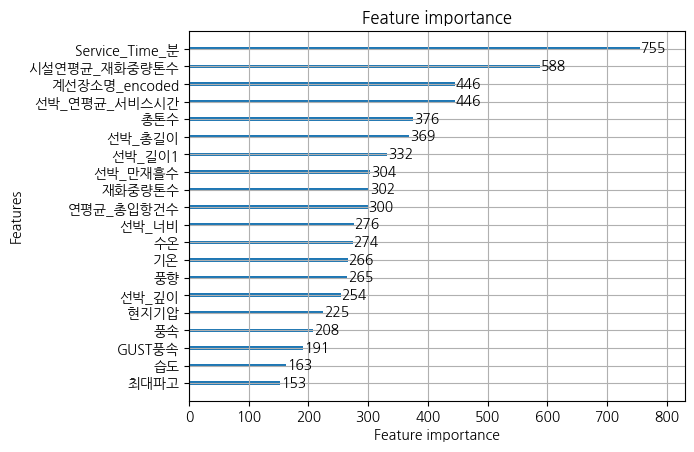

In [83]:
from sklearn.model_selection import KFold

x_cols = [
       'Service_Time_분','총톤수', '재화중량톤수',
       '선박_총길이', '선박_너비', '선박_만재흘수', '선박_깊이', '선박_길이1', '풍속',
       '풍향', 'GUST풍속', '현지기압', '습도', '기온', '수온',
       '최대파고', '유의파고', '평균파고', '파주기', '이전_입항선박수',
       '시설연평균_재화중량톤수', '연평균_총입항건수', '선박_연평균_서비스시간',
       '계선장소명_encoded']

# 데이터 불러오기 (주어진 데이터 사용)
data = df.copy()

# 특성과 타겟 변수 분리
X = data[x_cols]
y = data['접안_대기시간_분']

# 베이지안 옵티마이제이션 범위 설정
pbounds = {
    'num_leaves': (2, 100),           # num_leaves의 범위 설정
    'learning_rate': (0.01, 0.5),    # learning_rate의 범위 설정
    'feature_fraction': (0.1, 0.95),  # feature_fraction의 범위 설정
    'max_depth': (3, 30),
    'min_child_samples': (1, 50),     # min_child_samples의 범위 설정
    'reg_lambda': (0, 1)              # reg_lambda의 범위 설정
}

# 베이지안 옵티마이제이션 함수 정의
def lgb_cv(num_leaves, learning_rate, feature_fraction, max_depth, min_child_samples, reg_lambda):
    params = {
        'objective': 'regression',  # 회귀 문제 설정
        'metric': 'rmse',          # 평가 지표 (Root Mean Squared Error)
        'num_leaves': int(num_leaves),
        'learning_rate': max(min(learning_rate, 1), 0),  # learning_rate를 0과 1 사이로 제한
        'feature_fraction': max(min(feature_fraction, 1), 0),  # feature_fraction을 0과 1 사이로 제한
        'max_depth':int(max_depth),
        'min_child_samples': int(min_child_samples),
        'reg_lambda': max(min(reg_lambda, 1), 0)
    }

    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    rmses = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model = lgb.LGBMRegressor(**params)

        # 모델 학습
        model.fit(X_train, y_train)

        # 검증 데이터로 예측
        y_pred = model.predict(X_val)

        # 모델 평가 (RMSE 계산)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)

    return -np.mean(rmses)  # 목적 함수는 최소화해야 하므로 음수로 반환

# BayesianOptimization 객체 생성
optimizer = BayesianOptimization(
    f=lgb_cv,  # 최적화할 함수 지정
    pbounds=pbounds,  # 변수 범위 지정
    random_state=42,  # 랜덤 시드 설정
    verbose=2  # 로그 출력 레벨 설정
)

# 최적화 실행
optimizer.maximize(init_points=5, n_iter=10)

# 최적 하이퍼파라미터 출력
best_params = optimizer.max['params']
print("최적 하이퍼파라미터:", best_params)

# 최적 하이퍼파라미터로 모델 학습 및 평가
kf = KFold(n_splits=5, random_state=42, shuffle=True)
test_rmses = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    best_model = lgb.LGBMRegressor(
        objective='regression',
        metric='rmse',
        num_leaves=int(best_params['num_leaves']),
        learning_rate=best_params['learning_rate'],
        feature_fraction=best_params['feature_fraction'],
        min_child_samples=int(best_params['min_child_samples']),
        reg_lambda=best_params['reg_lambda']
    )

    # 모델 학습
    best_model.fit(X_train, y_train)

    # 검증 데이터로 예측
    y_pred = best_model.predict(X_val)

    # 모델 평가 (RMSE 계산)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    test_rmses.append(rmse)


# 예측 결과값의 범위 출력
print("예측 결과값 범위:")
print(f"최소 예측값: {np.min(y_pred)}")
print(f"최대 예측값: {np.max(y_pred)}")

print(f'평균 검증 RMSE (최적 모델): {np.mean(test_rmses)}')

# 최적 하이퍼파라미터로 모델 학습
best_model = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    num_leaves=int(best_params['num_leaves']),
    learning_rate=best_params['learning_rate'],
    feature_fraction=best_params['feature_fraction'],
    max_depth=int(best_params['max_depth']),
    min_child_samples=int(best_params['min_child_samples']),
    reg_lambda=best_params['reg_lambda']
)
best_model.fit(X_train, y_train)

# feature importance 시각화
plt.figure(figsize=(15, 12))
lgb.plot_importance(best_model, max_num_features=20, importance_type='split')  # split 기준으로 시각화 / importance_type='split': 노드에서 해당 특성을 분할하는 데 사용된 횟수
plt.show()

|   iter    |  target   | featur... | learni... | max_depth | min_ch... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] feature_fraction is set=0.4183591010202581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4183591010202581
[LightGBM] [Warning] feature_fraction is set=0.4183591010202581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4183591010202581
[LightGBM] [Warning] feature_fraction is set=0.4183591010202581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4183591010202581
[LightGBM] [Warning] feature_fraction is set=0.4183591010202581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4183591010202581
| 1         | -1.079e+0 | 0.4184    | 0.4759    | 22.76     | 30.33     | 17.29     | 0.156     | 0.05808   |
[LightGBM] [Warning] feature_fraction is set=0.8362497

<Figure size 1500x1200 with 0 Axes>

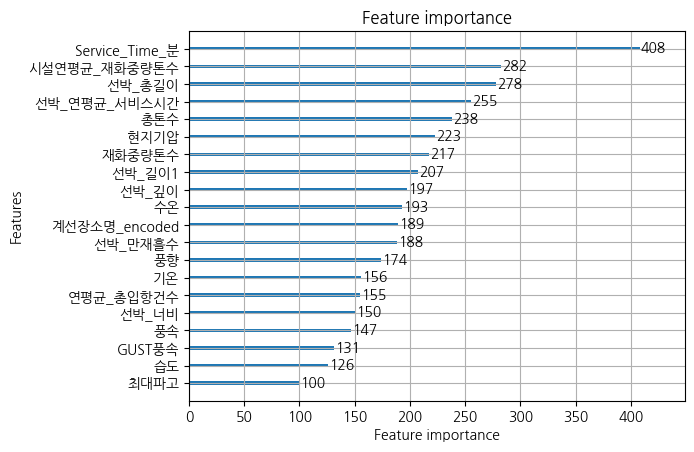

In [85]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
from bayes_opt import BayesianOptimization

x_cols = [
       'Service_Time_분','총톤수', '재화중량톤수',
       '선박_총길이', '선박_너비', '선박_만재흘수', '선박_깊이', '선박_길이1', '풍속',
       '풍향', 'GUST풍속', '현지기압', '습도', '기온', '수온',
       '최대파고', '유의파고', '평균파고', '파주기', '이전_입항선박수',
       '시설연평균_재화중량톤수', '연평균_총입항건수', '선박_연평균_서비스시간',
       '계선장소명_encoded']

# 데이터 불러오기 (주어진 데이터 사용)
data = df.copy()

# 특성과 타겟 변수 분리
X = data[x_cols]
y = data['접안_대기시간_분']

# 베이지안 옵티마이제이션 범위 설정
pbounds = {
    'num_leaves': (2, 100),           # num_leaves의 범위 설정
    'learning_rate': (0.01, 0.5),    # learning_rate의 범위 설정
    'feature_fraction': (0.1, 0.95),  # feature_fraction의 범위 설정
    'max_depth': (3, 30),
    'min_child_samples': (1, 50),     # min_child_samples의 범위 설정
    'reg_lambda': (0, 1),              # reg_lambda의 범위 설정
    'reg_alpha': (0, 1)               # L1 규제 강도 범위 설정 (0부터 1까지)
}

# 베이지안 옵티마이제이션 함수 정의
def lgb_cv(num_leaves, learning_rate, feature_fraction, max_depth, min_child_samples, reg_lambda, reg_alpha):
    params = {
        'objective': 'regression',  # 회귀 문제 설정
        'metric': 'rmse',          # 평가 지표 (Root Mean Squared Error)
        'num_leaves': int(num_leaves),
        'learning_rate': max(min(learning_rate, 1), 0),  # learning_rate를 0과 1 사이로 제한
        'feature_fraction': max(min(feature_fraction, 1), 0),  # feature_fraction을 0과 1 사이로 제한
        'max_depth':int(max_depth),
        'min_child_samples': int(min_child_samples),
        'reg_lambda': max(min(reg_lambda, 1), 0),
        'reg_alpha': max(min(reg_alpha, 1), 0)  # L1 규제 강도 설정
    }

    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    rmses = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model = lgb.LGBMRegressor(**params)

        # 모델 학습
        model.fit(X_train, y_train)

        # 검증 데이터로 예측
        y_pred = model.predict(X_val)

        # 모델 평가 (RMSE 계산)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)

    return -np.mean(rmses)  # 목적 함수는 최소화해야 하므로 음수로 반환

# BayesianOptimization 객체 생성
optimizer = BayesianOptimization(
    f=lgb_cv,  # 최적화할 함수 지정
    pbounds=pbounds,  # 변수 범위 지정
    random_state=42,  # 랜덤 시드 설정
    verbose=2  # 로그 출력 레벨 설정
)

# 최적화 실행
optimizer.maximize(init_points=5, n_iter=10)

# 최적 하이퍼파라미터 출력
best_params = optimizer.max['params']
print("최적 하이퍼파라미터:", best_params)

# 최적 하이퍼파라미터로 모델 학습 및 평가
kf = KFold(n_splits=5, random_state=42, shuffle=True)
test_rmses = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    best_model = lgb.LGBMRegressor(
        objective='regression',
        metric='rmse',
        num_leaves=int(best_params['num_leaves']),
        learning_rate=best_params['learning_rate'],
        feature_fraction=best_params['feature_fraction'],
        min_child_samples=int(best_params['min_child_samples']),
        reg_lambda=best_params['reg_lambda'],
        reg_alpha=best_params['reg_alpha']  # 최적 규제 강도 설정
    )

    # 모델 학습
    best_model.fit(X_train, y_train)

    # 검증 데이터로 예측
    y_pred = best_model.predict(X_val)

    # 모델 평가 (RMSE 계산)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    test_rmses.append(rmse)


# 예측 결과값의 범위 출력
print("예측 결과값 범위:")
print(f"최소 예측값: {np.min(y_pred)}")
print(f'평균 검증 RMSE (최적 모델): {np.mean(test_rmses)}')

# 최적 하이퍼파라미터로 모델 학습
best_model = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    num_leaves=int(best_params['num_leaves']),
    learning_rate=best_params['learning_rate'],
    feature_fraction=best_params['feature_fraction'],
    max_depth=int(best_params['max_depth']),
    min_child_samples=int(best_params['min_child_samples']),
    reg_lambda=best_params['reg_lambda'],
    reg_alpha=best_params['reg_alpha']  # 최적 규제 강도 설정
)
best_model.fit(X_train, y_train)

# feature importance 시각화
plt.figure(figsize=(15, 12))
lgb.plot_importance(best_model, max_num_features=20, importance_type='split')  # split 기준으로 시각화 / importance_type='split': 노드에서 해당 특성을 분할하는 데 사용된 횟수
plt.show()

### + PCA 추가

In [86]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import numpy as np
from bayes_opt import BayesianOptimization

x_cols = [
       'Service_Time_분','총톤수', '재화중량톤수',
       '선박_총길이', '선박_너비', '선박_만재흘수', '선박_깊이', '선박_길이1', '풍속',
       '풍향', 'GUST풍속', '현지기압', '습도', '기온', '수온',
       '최대파고', '유의파고', '평균파고', '파주기', '이전_입항선박수',
       '시설연평균_재화중량톤수', '연평균_총입항건수', '선박_연평균_서비스시간',
       '계선장소명_encoded']

# 데이터 불러오기 (주어진 데이터 사용)
data = df.copy()

# 특성과 타겟 변수 분리
X = data[x_cols]
y = data['접안_대기시간_분']

# 데이터 표준화 (또는 정규화)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA를 사용하여 차원 축소
n_components = 10  # 원하는 주성분의 수 설정
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# 베이지안 옵티마이제이션 범위 설정
pbounds = {
    'num_leaves': (2, 100),           # num_leaves의 범위 설정
    'learning_rate': (0.01, 0.5),    # learning_rate의 범위 설정
    'feature_fraction': (0.1, 0.95),  # feature_fraction의 범위 설정
    'max_depth': (3, 30),
    'min_child_samples': (1, 50),     # min_child_samples의 범위 설정
    'reg_lambda': (0, 1)              # reg_lambda의 범위 설정
}

# 베이지안 옵티마이제이션 함수 정의
def lgb_cv(num_leaves, learning_rate, feature_fraction, max_depth, min_child_samples, reg_lambda):
    params = {
        'objective': 'regression',  # 회귀 문제 설정
        'metric': 'rmse',          # 평가 지표 (Root Mean Squared Error)
        'num_leaves': int(num_leaves),
        'learning_rate': max(min(learning_rate, 1), 0),  # learning_rate를 0과 1 사이로 제한
        'feature_fraction': max(min(feature_fraction, 1), 0),  # feature_fraction을 0과 1 사이로 제한
        'max_depth':int(max_depth),
        'min_child_samples': int(min_child_samples),
        'reg_lambda': max(min(reg_lambda, 1), 0)
    }

    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    rmses = []

    for train_index, val_index in kf.split(X_pca):
        X_train, X_val = X_pca[train_index], X_pca[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model = lgb.LGBMRegressor(**params)

        # 모델 학습
        model.fit(X_train, y_train)

        # 검증 데이터로 예측
        y_pred = model.predict(X_val)

        # 모델 평가 (RMSE 계산)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)

    return -np.mean(rmses)  # 목적 함수는 최소화해야 하므로 음수로 반환

# BayesianOptimization 객체 생성
optimizer = BayesianOptimization(
    f=lgb_cv,  # 최적화할 함수 지정
    pbounds=pbounds,  # 변수 범위 지정
    random_state=42,  # 랜덤 시드 설정
    verbose=2  # 로그 출력 레벨 설정
)

# 최적화 실행
optimizer.maximize(init_points=5, n_iter=10)

# 최적 하이퍼파라미터 출력
best_params = optimizer.max['params']
print("최적 하이퍼파라미터:", best_params)

# 최적 하이퍼파라미터로 모델 학습 및 평가
kf = KFold(n_splits=5, random_state=42, shuffle=True)
test_rmses = []

for train_index, val_index in kf.split(X_pca):
    X_train, X_val = X_pca[train_index], X_pca[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    best_model = lgb.LGBMRegressor(
        objective='regression',
        metric='rmse',
        num_leaves=int(best_params['num_leaves']),
        learning_rate=best_params['learning_rate'],
        feature_fraction=best_params['feature_fraction'],
        min_child_samples=int(best_params['min_child_samples']),
        reg_lambda=best_params['reg_lambda']
    )

    # 모델 학습
    best_model.fit(X_train, y_train)

    # 검증 데이터로 예측
    y_pred = best_model.predict(X_val)

    # 모델 평가 (RMSE 계산)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    test_rmses.append(rmse)

# 예측 결과값의 범위 출력
print("예측 결과값 범위:")
print(f"최소 예측값: {np.min(y_pred)}")
print(f'평균 검증 RMSE (최적 모델): {np.mean(test_rmses)}')

# 최적 하이퍼파라미터로 모델 학습
best_model = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    num_leaves=int(best_params['num_leaves']),
    learning_rate=best_params['learning_rate'],
    feature_fraction=best_params['feature_fraction'],
    max_depth=int(best_params['max_depth']),
    min_child_samples=int(best_params['min_child_samples']),
    reg_lambda=best_params['reg_lambda'],
    reg_alpha=best_params['reg_alpha']  # 최적 규제 강도 설정
)
best_model.fit(X_train, y_train)

# feature importance 시각화
plt.figure(figsize=(15, 12))
lgb.plot_importance(best_model, max_num_features=20, importance_type='split')  # split 기준으로 시각화 / importance_type='split': 노드에서 해당 특성을 분할하는 데 사용된 횟수
plt.show()


|   iter    |  target   | featur... | learni... | max_depth | min_ch... | num_le... | reg_la... |
-------------------------------------------------------------------------------------------------
[LightGBM] [Warning] feature_fraction is set=0.4183591010202581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4183591010202581
[LightGBM] [Warning] feature_fraction is set=0.4183591010202581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4183591010202581
[LightGBM] [Warning] feature_fraction is set=0.4183591010202581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4183591010202581
[LightGBM] [Warning] feature_fraction is set=0.4183591010202581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4183591010202581
| 1         | -1.121e+0 | 0.4184    | 0.4759    | 22.76     | 30.33     | 17.29     | 0.156     |
[LightGBM] [Warning] feature_fraction is set=0.14937107034296954, colsample_bytree=1.0 wil

KeyError: 'reg_alpha'